# <p style="padding:15px; background-color:#FFFF00; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000"> Binary Classification with a Bank Churn Dataset</p>

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#FCFF00; font-size:100%; border-radius: 10px 10px;">
    <b> Goal: </b>
<br>
For this Episode of the Series, our task is to predict whether a customer continues with their account or closes it (e.g., churns).
</p> 

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#FCFF00; font-size:100%; border-radius: 10px 10px;">
    <b> Evaluation Metric (=AUC): </b>
<br>
In this Kaggle challenge, the submissions are evaluated on Area Under the ROC curve between the predicted probability and the observed target.
</p> 


# <p style="padding:15px; background-color:#FFFF00; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Import Libraries</p>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt

# scikit-learn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

# Models
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

# optuna for hyperparams tuning
import optuna
from optuna.samplers import TPESampler

# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

# <p style="padding:15px; background-color:#FFFF00; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Import the data</p> 

In [2]:
# files path
train_path     = "/kaggle/input/playground-series-s4e1/train.csv"
test_path      = "/kaggle/input/playground-series-s4e1/test.csv"
original_path  = "/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv"

# function to import our dataset 
def import_data(train_path, test_path, original_path):     
    train      =  pd.read_csv(train_path)
    test       =  pd.read_csv(test_path)
    original   =  pd.read_csv(original_path)
    
    return train, test, original

train, test, original = import_data(train_path, test_path, original_path)

# <p style="padding:15px; background-color:#FFFF00; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Exploratory Data Analysis - EDA</p> 

In [3]:
train.head(3)

id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   

   Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0      0.0              2        1.0             0.0        181449.97       0  
1      0.0              2        1.0             1.0         49503.50       0  
2      0.0              2        1.0             0.0        184866.69       0

In [4]:
train.shape

(165034, 14)

In [5]:
original.head(3)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender   Age  \
0          1    15634602  Hargrave          619    France  Female  42.0   
1          2    15647311      Hill          608     Spain  Female  41.0   
2          3    15619304      Onio          502    France  Female  42.0   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1        1.0             1.0   
1       1   83807.86              1        0.0             1.0   
2       8  159660.80              3        1.0             0.0   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1

In [6]:
test.head(3)

id  CustomerId   Surname  CreditScore Geography  Gender   Age  Tenure  \
0  165034    15773898  Lucchese          586    France  Female  23.0       2   
1  165035    15782418      Nott          683    France  Female  46.0       2   
2  165036    15807120        K?          656    France  Female  34.0       7   

   Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0      0.0              2        0.0             1.0        160976.75  
1      0.0              1        1.0             0.0         72549.27  
2      0.0              2        1.0             0.0        138882.09

# <p style="padding:15px; background-color:#FFFF00; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">1. Univariate Analysis</p> 

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


With the .describe() method from pandas we can see basic stats like **count, mean, standard deviation, minimum, maximum, quantiles...**

In [8]:
train.describe().T

count          mean           std          min  \
id               165034.0  8.251650e+04  47641.356500         0.00   
CustomerId       165034.0  1.569201e+07  71397.816791  15565701.00   
CreditScore      165034.0  6.564544e+02     80.103340       350.00   
Age              165034.0  3.812589e+01      8.867205        18.00   
Tenure           165034.0  5.020353e+00      2.806159         0.00   
Balance          165034.0  5.547809e+04  62817.663278         0.00   
NumOfProducts    165034.0  1.554455e+00      0.547154         1.00   
HasCrCard        165034.0  7.539537e-01      0.430707         0.00   
IsActiveMember   165034.0  4.977702e-01      0.499997         0.00   
EstimatedSalary  165034.0  1.125748e+05  50292.865585        11.58   
Exited           165034.0  2.115988e-01      0.408443         0.00   

                         25%         50%           75%          max  
id                  41258.25     82516.5  1.237748e+05    165033.00  
CustomerId       15633141.00  15690169.0  1.575682e+07  15815690.00  
CreditScore           597.00       659.0  7.100000e+02       850.00  
Age                    32.00        37.0  4.200000e+01        92.00  
Tenure                  3.00         5.0  7.000000e+00        10.00  
Balance                 0.00         0.0  1.199395e+05    250898.09  
NumOfProducts           1.00         2.0  2.000000e+00         4.00  
HasCrCard               1.00         1.0  1.000000e+00         1.00  
IsActiveMember          0.00         0.0  1.000000e+00         1.00  
EstimatedSalary     74637.57    117948.0  1.551525e+05    199992.48  
Exited                  0.00         0.0  0.000000e+00         1.00

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#FCFF00; font-size:100%; border-radius: 15px 15px;">
    <b>💡 
From the count column we can see that there is no missing values in the train dataset. <br>
Let's be sure about this assumption for the test and the original datasets. <br>
To achieve this, we will define our own function for univariate statistics with more informations such as the mode, skewness and kurtosis...
</b>
</p> 

In [9]:
# List of numerical columns and categorical columns

numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
binary_cols  = ['HasCrCard', 'IsActiveMember']
categ_cols   = train.select_dtypes(include=['object']).columns.tolist()
target       = 'Exited'

print(f"Numerical columns list   ---> {numeric_cols}")
print(f"Binary columns list      ---> {binary_cols}")
print(f"Categorical columns list ---> {categ_cols}")

Numerical columns list   ---> ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
Binary columns list      ---> ['HasCrCard', 'IsActiveMember']
Categorical columns list ---> ['Surname', 'Geography', 'Gender']


In [10]:
# fonction to calculate univariate stats like pandas describe method
def univariate_stats(df):
    #df.drop('id', axis=1, inplace=True)
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df[numeric_cols + categ_cols]:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]

    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [11]:
# Call the function on train
univariate_stats(train)

Count  Missing  Unique    Dtype  IsNumeric      Mode  \
EstimatedSalary  165034        0   55298  float64       True  88890.05   
Balance          165034        0   30075  float64       True       0.0   
CreditScore      165034        0     457    int64       True     850.0   
Age              165034        0      71  float64       True      37.0   
Tenure           165034        0      11    int64       True       2.0   
NumOfProducts    165034        0       4    int64       True       2.0   
Surname          165034        0    2797   object      False      Hsia   
Geography        165034        0       3   object      False    France   
Gender           165034        0       2   object      False      Male   

                          Mean    Min       25%    Median          75%  \
EstimatedSalary  112574.822734  11.58  74637.57  117948.0  155152.4675   
Balance           55478.086689    0.0       0.0       0.0  119939.5175   
CreditScore         656.454373  350.0     597.0     659.0        710.0   
Age                  38.125888   18.0      32.0      37.0         42.0   
Tenure                5.020353    0.0       3.0       5.0          7.0   
NumOfProducts         1.554455    1.0       1.0       2.0          2.0   
Surname                      -      -         -         -            -   
Geography                    -      -         -         -            -   
Gender                       -      -         -         -            -   

                       Max           Std      Skew      Kurt  
EstimatedSalary  199992.48  50292.865585 -0.309022 -0.838845  
Balance          250898.09  62817.663278   0.38202 -1.600852  
CreditScore          850.0      80.10334 -0.059291 -0.067452  
Age                   92.0      8.867205  0.968063  1.532406  
Tenure                10.0      2.806159   0.00649 -1.157921  
NumOfProducts          4.0      0.547154  0.368278 -0.278059  
Surname                  -             -         -         -  
Geography                -             -         -         -  
Gender                   -             -         -         -

In [12]:
# Call the function to check univariate stats on the original dataset
univariate_stats(original)

Count  Missing  Unique    Dtype  IsNumeric      Mode  \
EstimatedSalary  10002        0    9999  float64       True  24924.92   
Balance          10002        0    6382  float64       True       0.0   
CreditScore      10002        0     460    int64       True     850.0   
Age              10001        1      73  float64       True      37.0   
Tenure           10002        0      11    int64       True       2.0   
NumOfProducts    10002        0       4    int64       True       1.0   
Surname          10002        0    2932   object      False     Smith   
Geography        10001        1       3   object      False    France   
Gender           10002        0       2   object      False      Male   

                          Mean    Min       25%     Median          75%  \
EstimatedSalary  100083.331145  11.58  50983.75  100185.24  149383.6525   
Balance           76491.112875    0.0       0.0   97198.54    127647.84   
CreditScore         650.555089  350.0     584.0      652.0        718.0   
Age                  38.922311   18.0      32.0       37.0         44.0   
Tenure                5.012498    0.0       3.0        5.0          7.0   
NumOfProducts         1.530194    1.0       1.0        1.0          2.0   
Surname                      -      -         -          -            -   
Geography                    -      -         -          -            -   
Gender                       -      -         -          -            -   

                       Max           Std      Skew      Kurt  
EstimatedSalary  199992.48  57508.117802  0.002321 -1.181446  
Balance          250898.09  62393.474144 -0.141295 -1.489231  
CreditScore          850.0     96.661615 -0.071878  -0.42634  
Age                   92.0       10.4872  1.011292  1.395677  
Tenure                10.0      2.891973  0.011267 -1.165051  
NumOfProducts          4.0      0.581639  0.745485  0.582777  
Surname                  -             -         -         -  
Geography                -             -         -         -  
Gender                   -             -         -         -

In [13]:
# Call the function to check univariate stats on test dataset
univariate_stats(test)

Count  Missing  Unique    Dtype  IsNumeric      Mode  \
EstimatedSalary  110023        0   41670  float64       True  88890.05   
Balance          110023        0   22513  float64       True       0.0   
CreditScore      110023        0     454    int64       True     850.0   
Age              110023        0      74  float64       True      38.0   
Tenure           110023        0      11    int64       True       2.0   
NumOfProducts    110023        0       4    int64       True       2.0   
Surname          110023        0    2708   object      False      Hsia   
Geography        110023        0       3   object      False    France   
Gender           110023        0       2   object      False      Male   

                          Mean    Min        25%     Median         75%  \
EstimatedSalary  112315.147765  11.58  74440.325  117832.23   154631.35   
Balance           55333.611354    0.0        0.0        0.0  120145.605   
CreditScore         656.530789  350.0      597.0      660.0       710.0   
Age                  38.122205   18.0       32.0       37.0        42.0   
Tenure                4.996637    0.0        3.0        5.0         7.0   
NumOfProducts         1.553321    1.0        1.0        2.0         2.0   
Surname                      -      -          -          -           -   
Geography                    -      -          -          -           -   
Gender                       -      -          -          -           -   

                       Max           Std      Skew      Kurt  
EstimatedSalary  199992.48  50277.048244 -0.305291 -0.841998  
Balance          250898.09  62788.519675  0.385218 -1.602315  
CreditScore          850.0     80.315415 -0.062401 -0.068427  
Age                   92.0       8.86155  0.972404  1.588648  
Tenure                10.0      2.806148  0.021346 -1.152985  
NumOfProducts          4.0      0.544714  0.350358 -0.324378  
Surname                  -             -         -         -  
Geography                -             -         -         -  
Gender                   -             -         -         -

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#FCFF00; font-size:100%; border-radius: 15px 15px;">
    <b>💡 
Let's visualize some graphics to gain more insights. <br>
</b>
</p> 

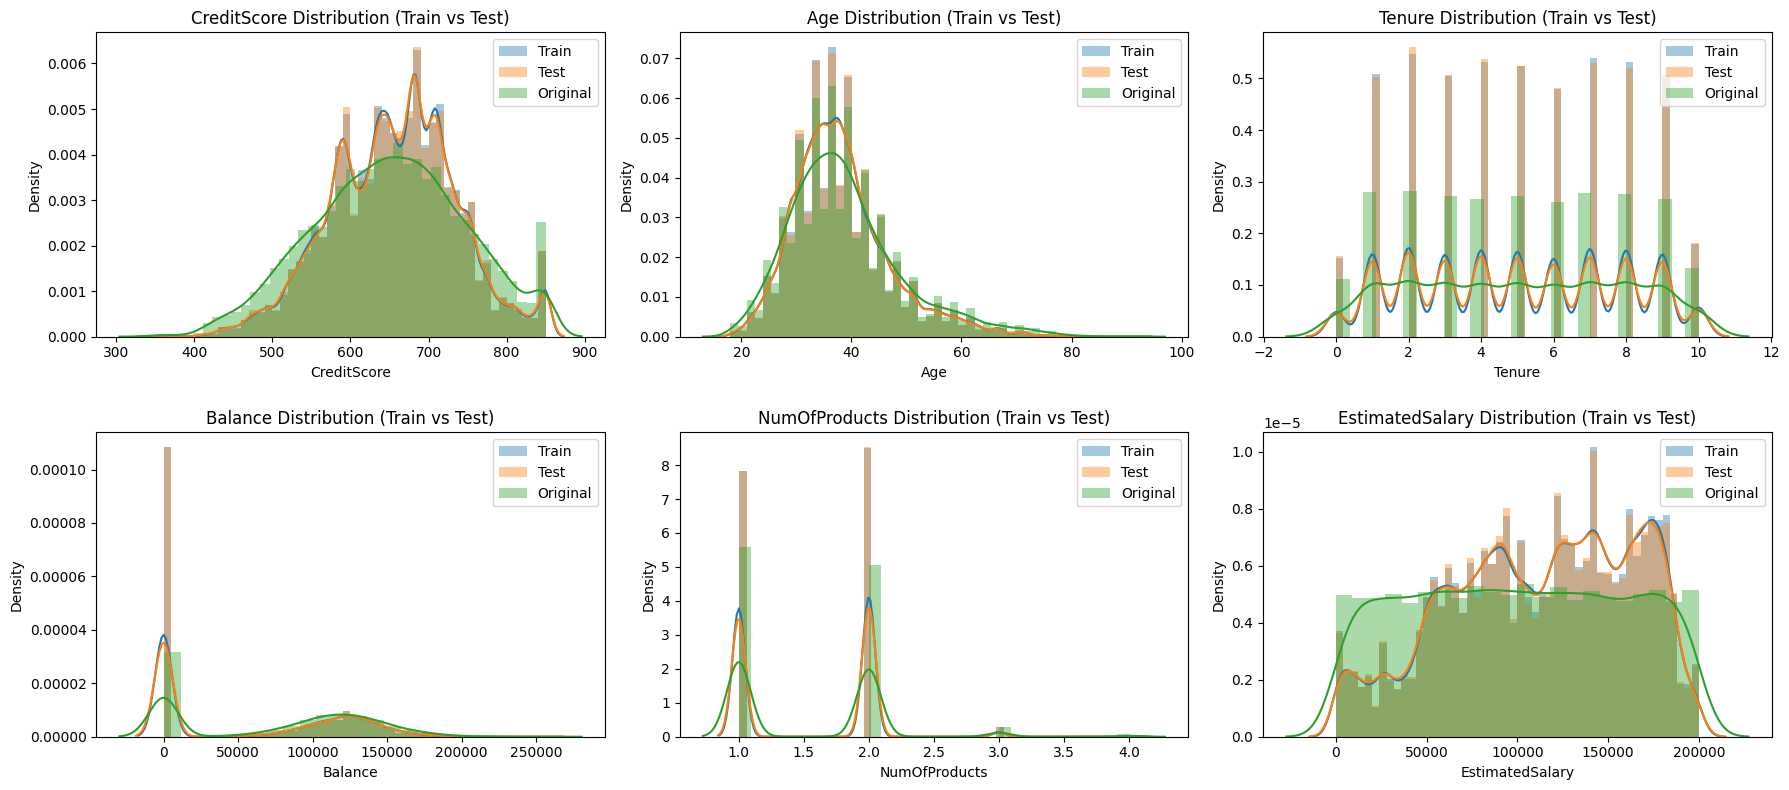

In [14]:
def plot_histograms(df_train, df_test, original, target, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        if var_name != target:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
        sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()
        
plot_histograms(train[numeric_cols], test[numeric_cols], original[numeric_cols], target, n_cols=3)

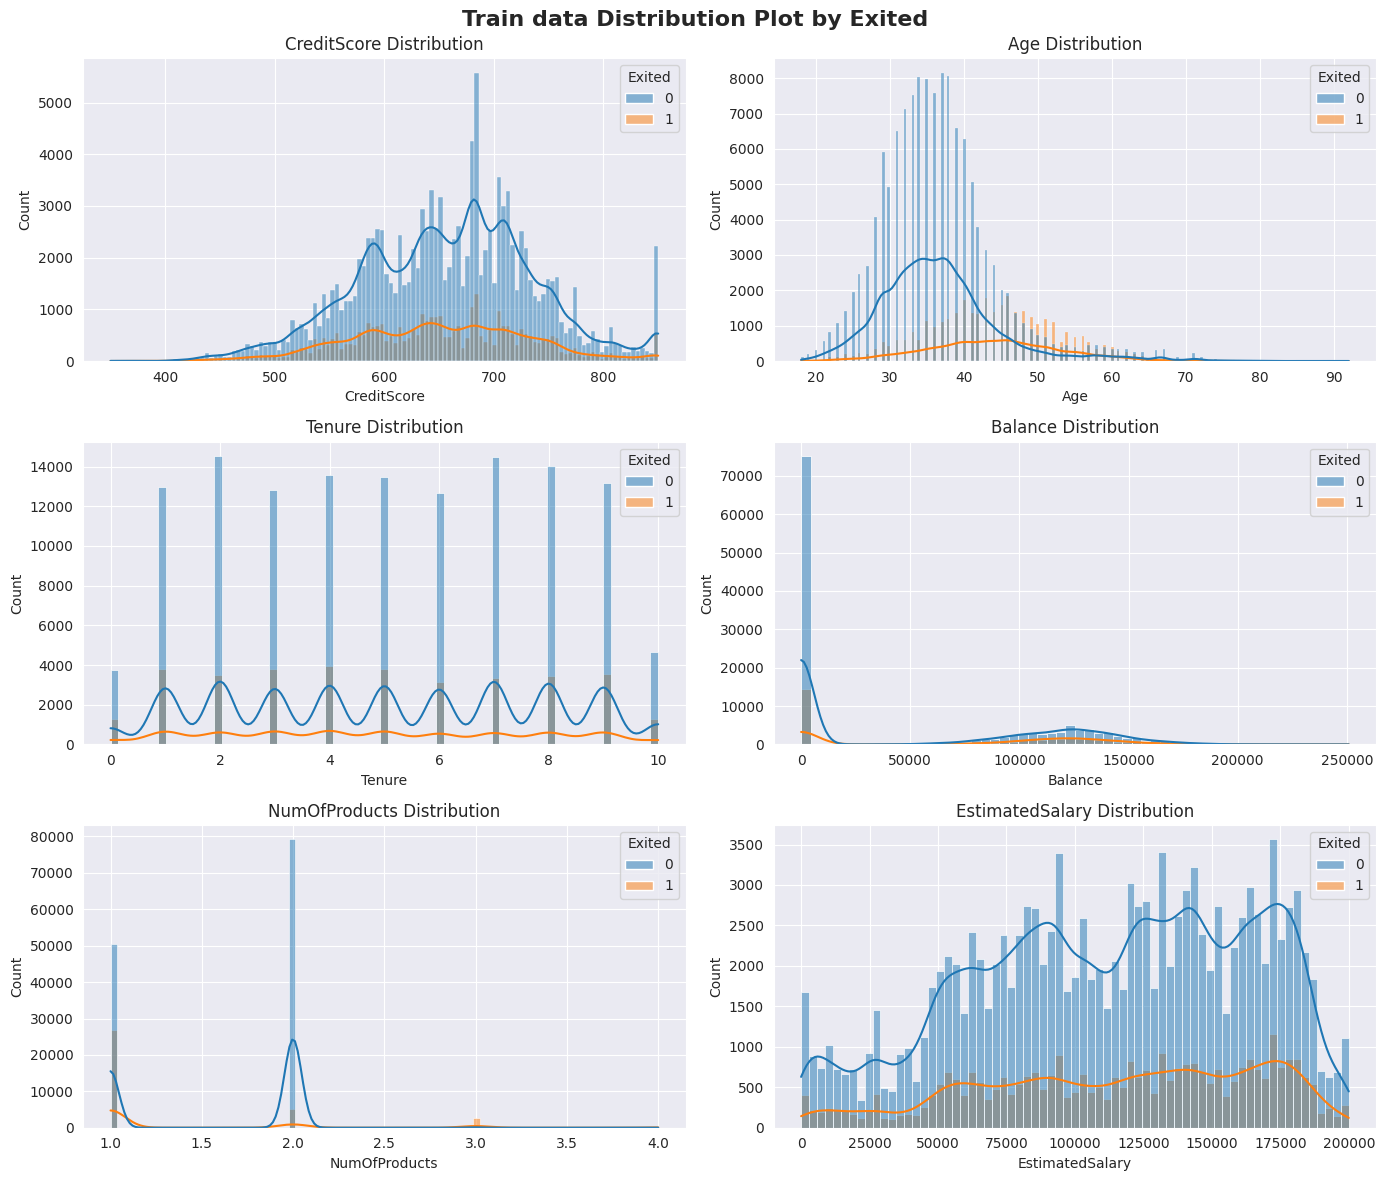

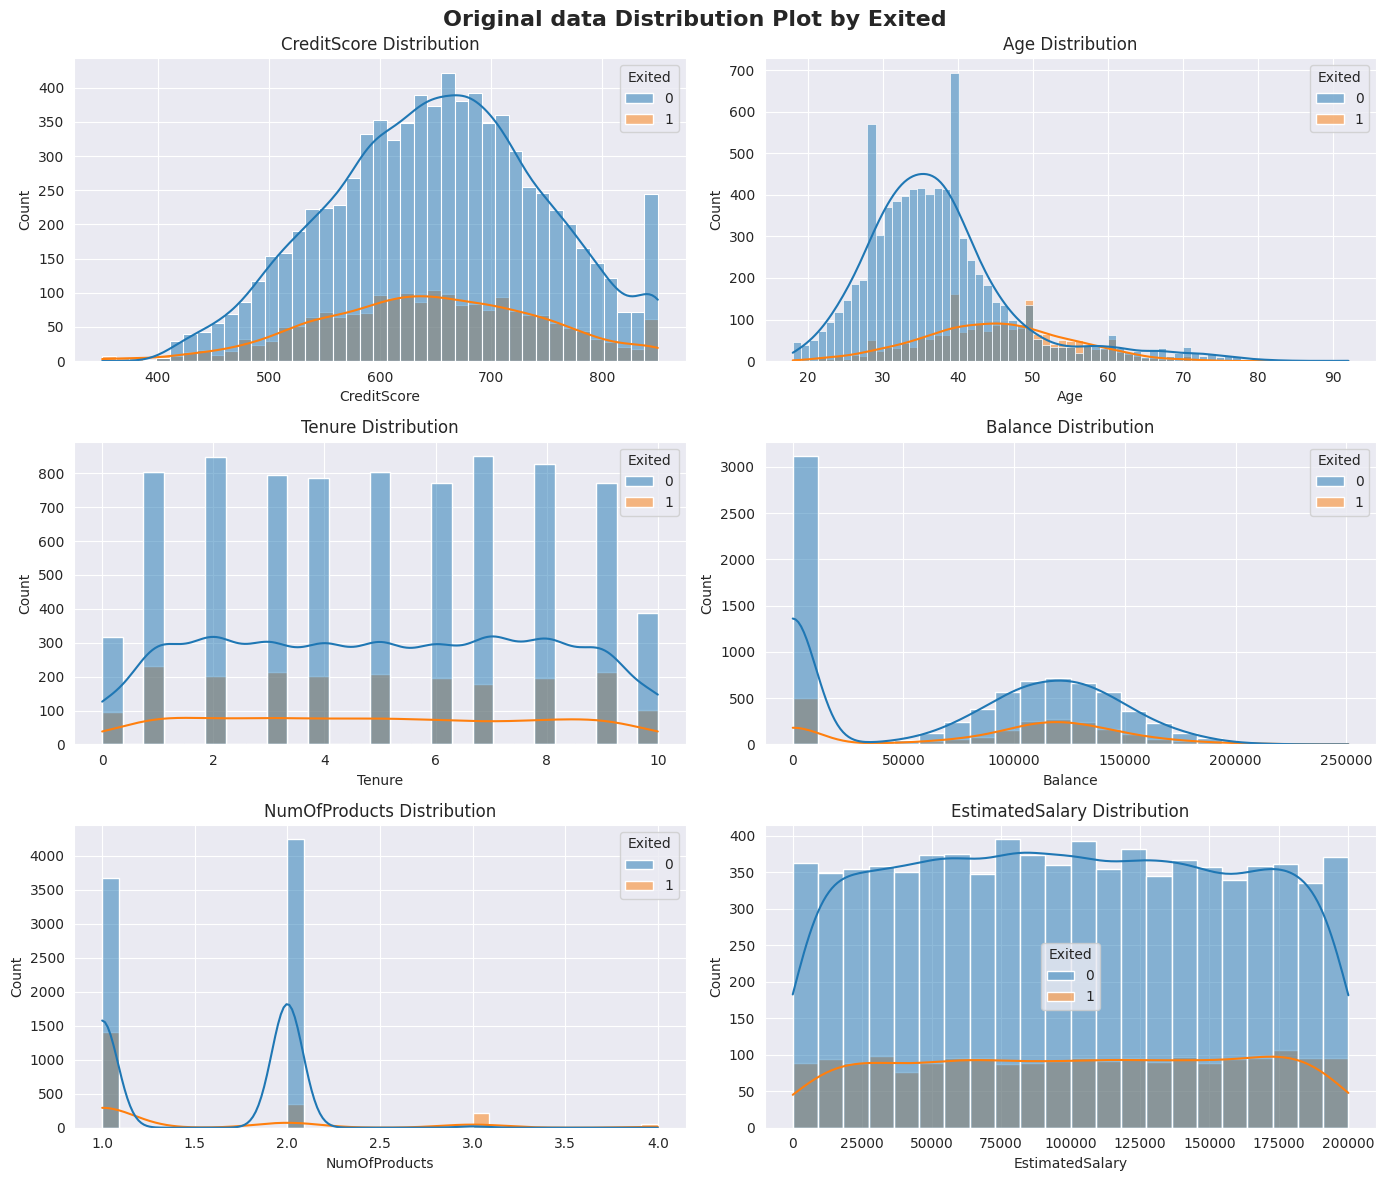

In [15]:
def plot_distribution(df, hue, title='', drop_cols=[]):
    sns.set_style('darkgrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.histplot(data=df, x=var_name, kde=True, ax=ax, hue=hue) # sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        ax.set_title(f'{var_name} Distribution')

    fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_distribution(train[numeric_cols+[target]], hue=target, title='Train data')
#plot_distribution(test[numeric_cols+[target]], hue=target, title='Test data')
plot_distribution(original[numeric_cols+[target]], hue=target, title='Original data')

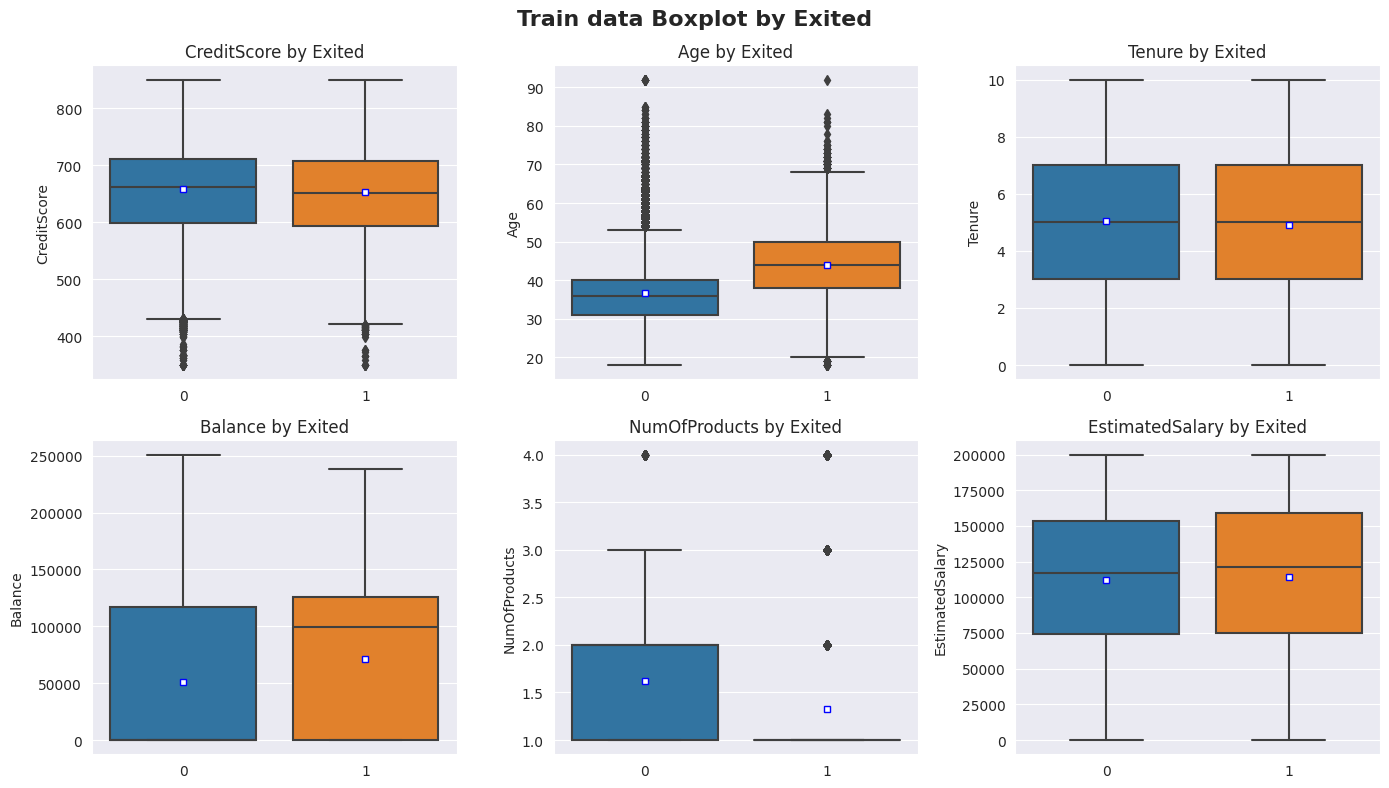

In [16]:
def plot_boxplot(df, hue, title='', drop_cols=[], n_cols=3):
    sns.set_style('darkgrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.boxplot(data=df, x=hue, y=var_name, ax=ax, showmeans=True, 
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
        ax.set_title(f'{var_name} by {hue}')
        ax.set_xlabel('')

    fig.suptitle(f'{title} Boxplot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_boxplot(train[numeric_cols+[target]], hue=target, n_cols=3, title='Train data')
plot_boxplot(original[numeric_cols+[target]], hue=target, n_cols=3, title='Original data')

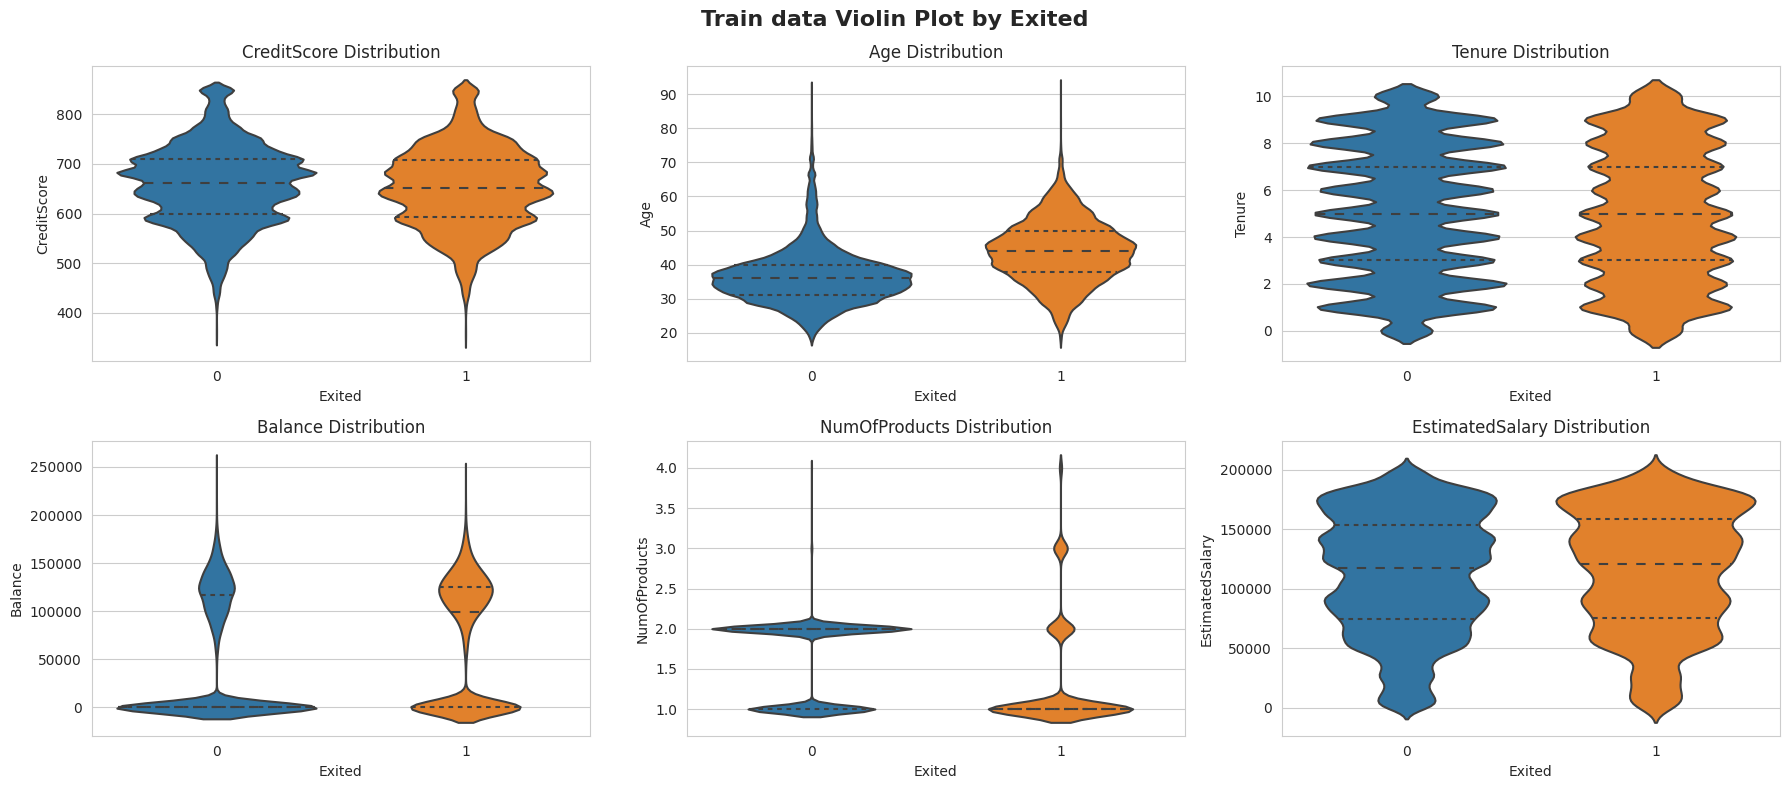

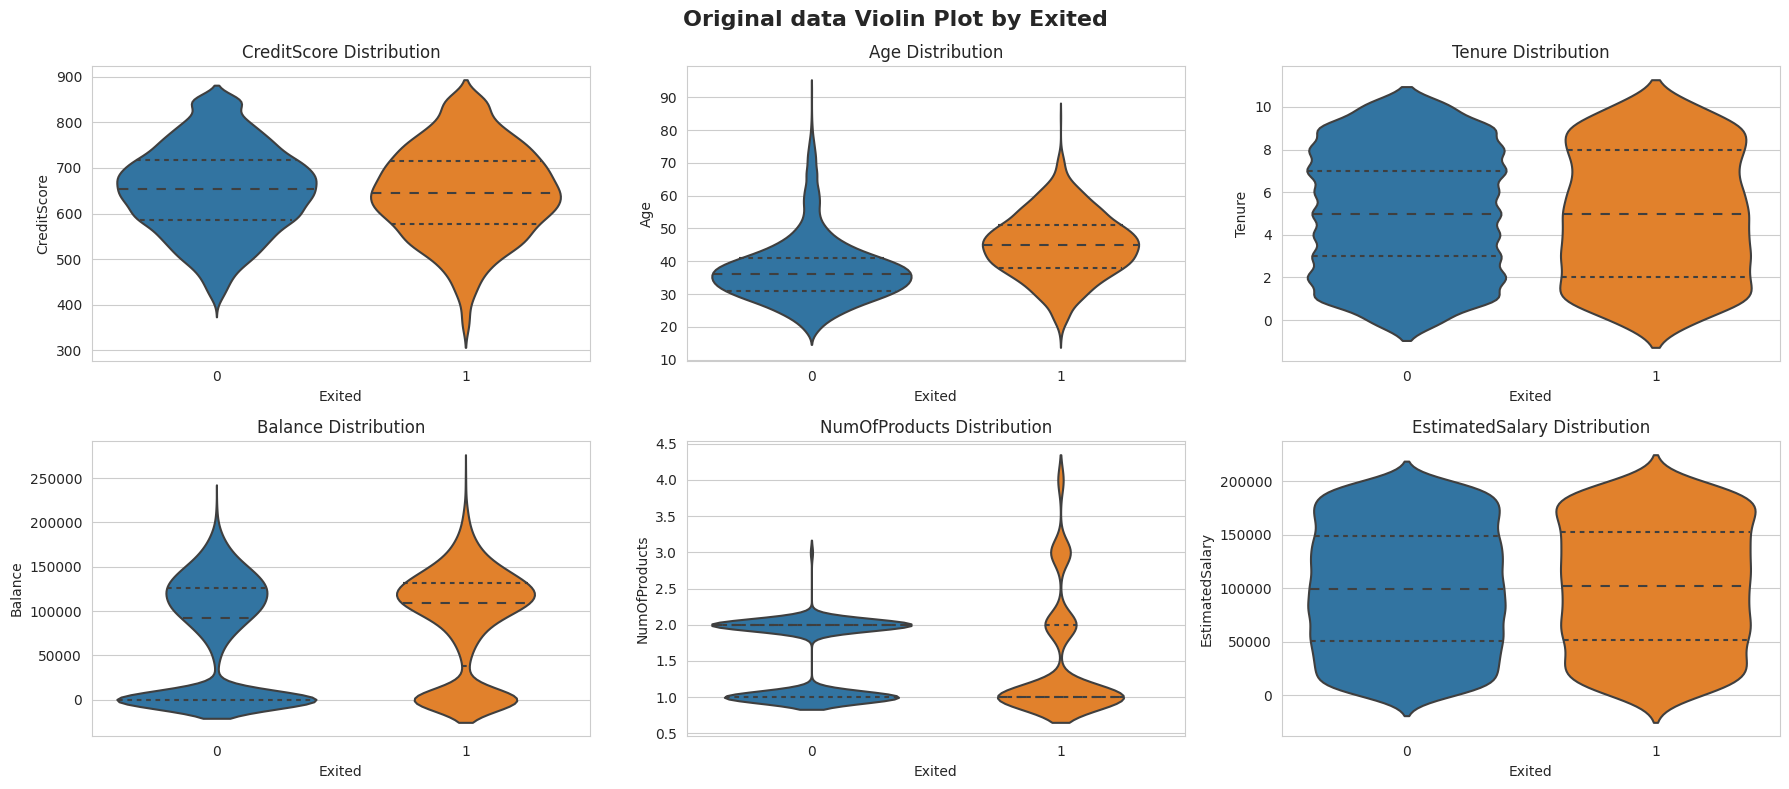

In [17]:
def plot_violinplot(df, hue, drop_cols=[], n_cols=2, title=''):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.violinplot(data=df, x=hue, y=var_name, ax=ax, inner='quartile')
        ax.set_title(f'{var_name} Distribution')

    fig.suptitle(f'{title} Violin Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_violinplot(train[numeric_cols+[target]], hue=target, n_cols=3, title='Train data')
plot_violinplot(original[numeric_cols+[target]], hue=target, n_cols=3, title='Original data')

In [18]:
#function to visualize the binary machine failures
def plot_binary_machine_failures(dataframe, column):
    # Plot the machine failures
    plt.figure(figsize=(4, 4))

    # Countplot for Machine failure
    ax = plt.subplot(1, 2, 1)
    ax = sns.countplot(x=column, data=dataframe)
    ax.bar_label(ax.containers[0])
    plt.title(column, fontsize=10)

    # Pie chart for Outcome
    ax = plt.subplot(1, 2, 2)
    outcome_counts = dataframe[column].value_counts()
    ax = outcome_counts.plot.pie(explode=[0.1, 0.1], autopct='%1.2f%%', shadow=True)
    ax.set_title("Pie", fontsize=20, color='Red', font='Lucida Calligraphy')

    # Display the plot
    plt.tight_layout()
    plt.show()

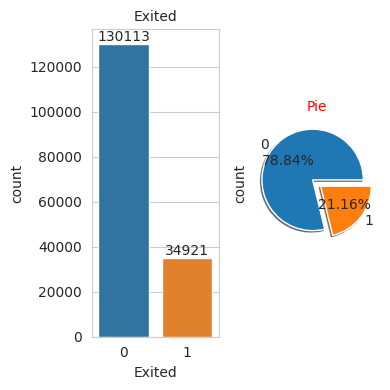

In [19]:
# Visualize the target balance
plot_binary_machine_failures(train, target)

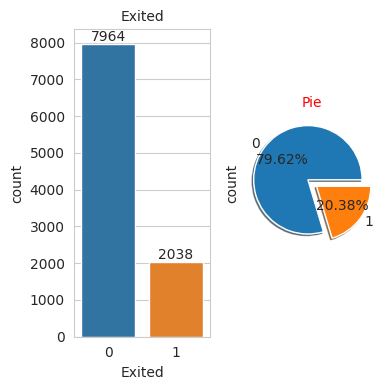

In [20]:
# Visualize the target balance
plot_binary_machine_failures(original, target)

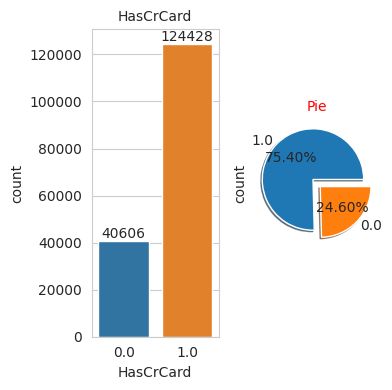

In [21]:
plot_binary_machine_failures(train, binary_cols[0])

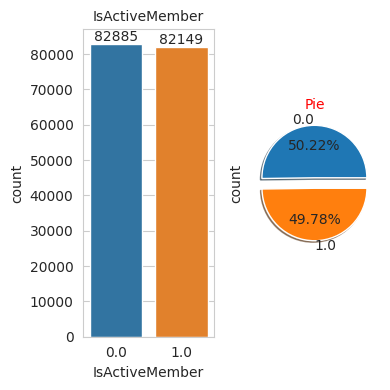

In [22]:
plot_binary_machine_failures(train, binary_cols[1])

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#FCFF00; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Additional Insights:<br><br>
1. From the above analysis, it can be seen that the target and the HasCrCard columns are imbalanced <br>
2. Inversely the IsActiveMember column is well balanced
</b>
</p> 

# <p style="padding:15px; background-color:#FFFF00; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">2. Bivariate Analysis</p> 

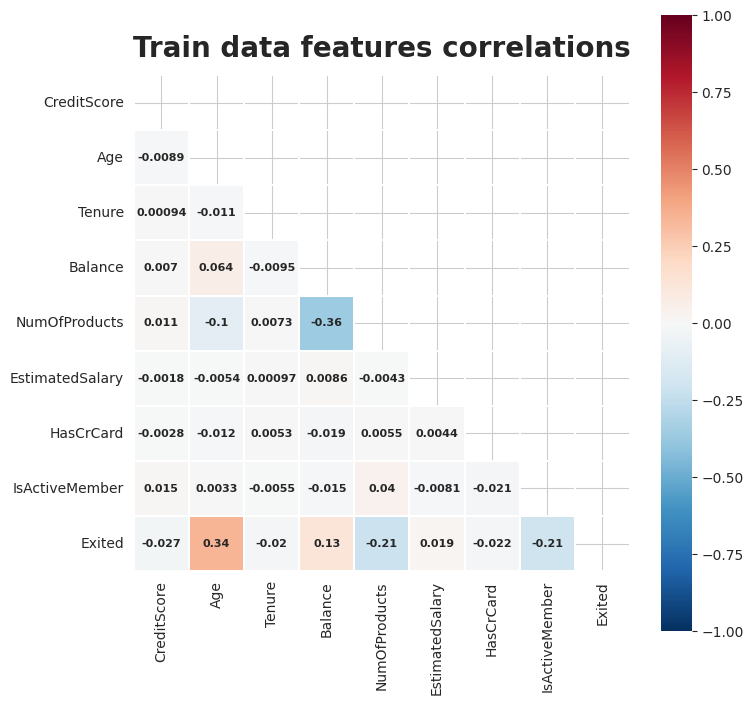

In [23]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(8, 8))

    # Set the title and font properties
    plt.title(f'{title} features correlations', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 8, "weight": "bold"},
                mask=mask)

plot_heatmap(train[numeric_cols+binary_cols+[target]], title='Train data')
plot_heatmap(original[numeric_cols+binary_cols+[target]], title='Original')

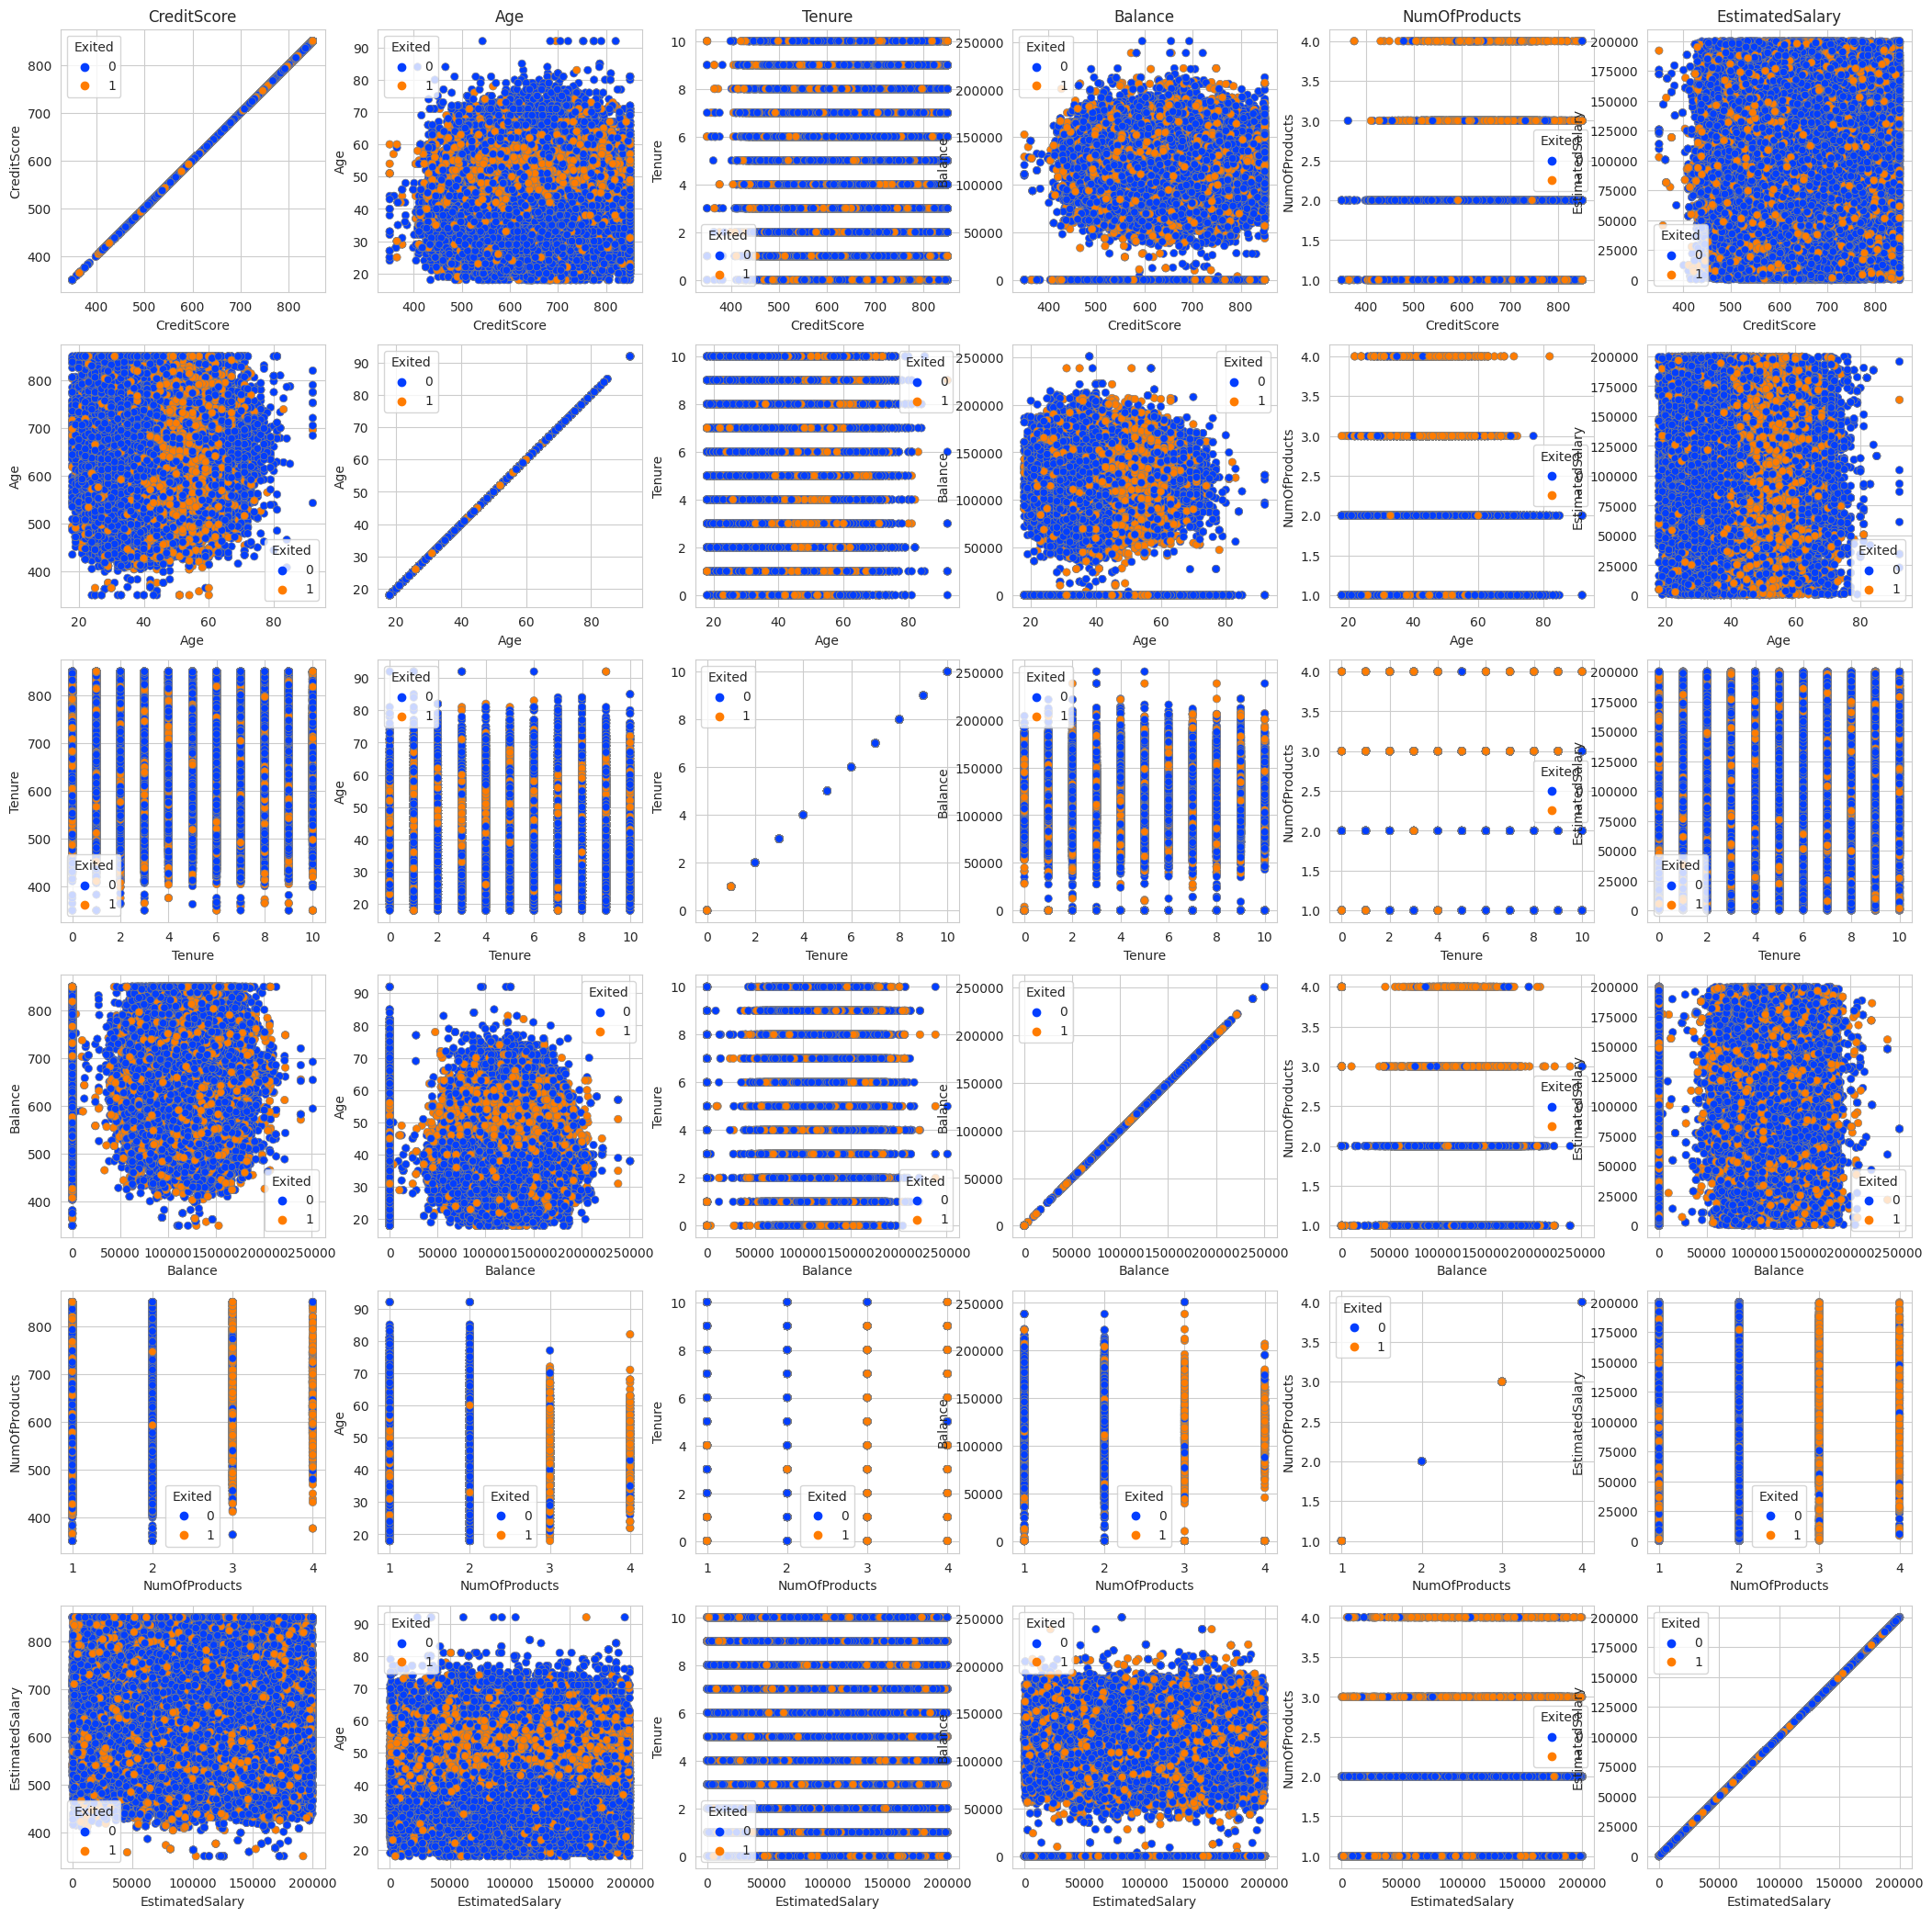

In [24]:
def plot_scatter_matrix(df, target_col, drop_cols=[], size=26):
    # sns.pairplot()
    
    sns.set_style('whitegrid')
    cols = df.columns.drop([target_col] + drop_cols)
    fig, axes = plt.subplots(len(cols), len(cols), figsize=(size, size), sharex=False, sharey=False)

    for i, col in enumerate(cols):
        for j, col_ in enumerate(cols):
            axes[i,j].set_xlabel(f'{col}')
            axes[i,j].set_ylabel(f'{col_}')

            # Plot the scatterplot
            sns.scatterplot(data=df, x=col, y=col_, hue=target_col, ax=axes[i,j],
                             edgecolor='gray', palette='bright')

            axes[i,j].tick_params(axis='both', which='major')

            if i == 0:
                axes[i,j].set_title(f'{col_}')
            if j == 0:
                axes[i,j].set_ylabel(f'{col}')
                
    plt.show()
    
plot_scatter_matrix(train[numeric_cols+[target]], target)

# <p style="padding:15px; background-color:#FFFF00; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Feature Engineering</p> 

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#FCFF00; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Combining Original and Training Dataset
        <br><br>
        I've concateneted the training dataset and the original rows where exited is "1" due to the fact that the train dataset is imbalanced.
</b>
</p> 

In [25]:
original_true_labels = original[original[target] == 1].drop('RowNumber', axis=1)
print("Original Data Shape: ", original_true_labels.shape)

# concatenate datasets
df_all = pd.concat([train, original_true_labels], ignore_index=True)
df_all = df_all.drop_duplicates()
df_all

Original Data Shape:  (2038, 13)


id  CustomerId         Surname  CreditScore Geography  Gender   Age  \
0       0.0    15674932  Okwudilichukwu          668    France    Male  33.0   
1       1.0    15749177   Okwudiliolisa          627    France    Male  33.0   
2       2.0    15694510           Hsueh          678    France    Male  40.0   
3       3.0    15741417             Kao          581    France    Male  34.0   
4       4.0    15766172       Chiemenam          716     Spain    Male  33.0   
...     ...         ...             ...          ...       ...     ...   ...   
167066  NaN    15672754        Burbidge          498   Germany    Male  42.0   
167067  NaN    15768163         Griffin          655   Germany  Female  46.0   
167068  NaN    15769959     Ajuluchukwu          597    France  Female  53.0   
167069  NaN    15584532             Liu          709    France  Female  36.0   
167070  NaN    15682355       Sabbatini          772   Germany    Male  42.0   

        Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0            3       0.00              2        1.0             0.0   
1            1       0.00              2        1.0             1.0   
2           10       0.00              2        1.0             0.0   
3            2  148882.54              1        1.0             1.0   
4            5       0.00              2        1.0             1.0   
...        ...        ...            ...        ...             ...   
167066       3  152039.70              1        1.0             1.0   
167067       7  137145.12              1        1.0             0.0   
167068       4   88381.21              1        1.0             0.0   
167069       7       0.00              1        0.0             1.0   
167070       3   75075.31              2        1.0             0.0   

        EstimatedSalary  Exited  
0             181449.97       0  
1              49503.50       0  
2             184866.69       0  
3              84560.88       0  
4              15068.83       0  
...                 ...     ...  
167066         53445.17       1  
167067        115146.40       1  
167068         69384.71       1  
167069         42085.58       1  
167070         92888.52       1  

[167071 rows x 14 columns]

In [26]:
# Visualize the target balance
plot_binary_machine_failures(df_all, target)

In [27]:
df_all.Surname.value_counts()

Surname
Hsia            2461
T'ien           2284
Hs?             1614
Maclean         1582
Kao             1580
                ... 
Wickens            1
Speth              1
Cleveland          1
Suttor             1
Rapuluchukwu       1
Name: count, Length: 2827, dtype: int64

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#FCFF00; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Adding new features : <br><br>
        When dealing with an imbalanced dataset, feature engineering can play a crucial role in improving the performance of our machine learning models.    
        Later we'll try to add many new features
</b>
</p> 

In [28]:
# function to add more features to the dataset
def feature_engineering(df): 
    # Create interaction features

    # Create time-based features

    news_cols = []
    return df, news_cols

# adding features
train_eng, news_cols   = feature_engineering(df_all)
test_eng, news_cols    = feature_engineering(test)

# updating numeric_cols
numeric_cols = numeric_cols + news_cols

In [29]:
# Prepare our dataset
train_eng.drop(columns=["id", "CustomerId", "Surname"], inplace=True, axis=1)

test_id = test_eng["id"]      # keeping this for submission
test_eng.drop(columns= ["id", "CustomerId", "Surname"], inplace=True, axis=1)
test_eng.head(3)

CreditScore Geography  Gender   Age  Tenure  Balance  NumOfProducts  \
0          586    France  Female  23.0       2      0.0              2   
1          683    France  Female  46.0       2      0.0              1   
2          656    France  Female  34.0       7      0.0              2   

   HasCrCard  IsActiveMember  EstimatedSalary  
0        0.0             1.0        160976.75  
1        1.0             0.0         72549.27  
2        1.0             0.0        138882.09

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#FCFF00; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Encoding & Scaling: <br><br>
        For this task I'll use CatBoostClassifier(which is a Gradient Boosting Decision Trees - GBDT model) so encoding and scaling may not be necessary here.

</b>
</p> 

In [30]:
X  = train_eng.drop(columns=[target], axis=1)
y  = train_eng[target]
y.head(3)

0    0
1    0
2    0
Name: Exited, dtype: int64

In [31]:
X.head(3)

CreditScore Geography Gender   Age  Tenure  Balance  NumOfProducts  \
0          668    France   Male  33.0       3      0.0              2   
1          627    France   Male  33.0       1      0.0              2   
2          678    France   Male  40.0      10      0.0              2   

   HasCrCard  IsActiveMember  EstimatedSalary  
0        1.0             0.0        181449.97  
1        1.0             1.0         49503.50  
2        1.0             0.0        184866.69

# <p style="padding:15px; background-color:#FFFF00; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">CatBoost Model building</p>

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#FCFF00; font-size:100%; border-radius: 15px 15px;">
    <b>💡 CatBoostClassifier: <br><br>
        CatBoost is a supervised machine learning method that uses decision trees for classification. As its name suggests, CatBoost has two main features, it works with categorical data (the Cat) and it uses gradient boosting (the Boost). Gradient boosting is a process in which many decision trees are constructed iteratively. Each subsequent tree improves the result of the previous tree, leading to better results. <br>
CatBoost overcomes a limitation of other decision tree-based methods in which, typically, the data must be pre-processed to convert categorical string variables to numerical values, one-hot-encodings, and so on. This method can directly consume a combination of categorical and non-categorical explanatory variables without preprocessing. It preprocesses as part of the algorithm. 
        CatBoost uses ordered encoding to encode categorical features and also uses symmetric trees. <br>
CatBoost can also be faster than other methods such as XGBoost. It retains certain features—such as cross-validation, regularization, and missing value support—from the prior algorithms. This method performs well with both small data and large data.

</b>
</p> 

In [32]:
submission = pd.read_csv("/kaggle/input/playground-series-s4e1/sample_submission.csv")

## **Preparing the data for CatBoost**

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
features_names_list = X_train.columns.tolist()

train_pool    = Pool(X_train.to_numpy(), y_train.to_numpy(), feature_names = features_names_list, cat_features = ['Geography', 'Gender'])
val_pool      = Pool(X_val.to_numpy(), y_val.to_numpy(),     feature_names = features_names_list, cat_features = ['Geography', 'Gender'])

test_pool     = Pool(test.to_numpy(),                        feature_names = features_names_list, cat_features = ['Geography', 'Gender'])

X_pool        = Pool(X.to_numpy(), y.to_numpy(),             feature_names = features_names_list, cat_features = ['Geography', 'Gender'])

## **Basic Approach**

In [34]:
model = CatBoostClassifier(random_seed=42, eval_metric='AUC')
model.fit(train_pool, eval_set=val_pool, 
          verbose=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.106176
0:	test: 0.8621241	best: 0.8621241 (0)	total: 149ms	remaining: 2m 29s
50:	test: 0.8850292	best: 0.8850292 (50)	total: 3.65s	remaining: 1m 7s
100:	test: 0.8859239	best: 0.8859239 (100)	total: 7.07s	remaining: 1m 2s
150:	test: 0.8862597	best: 0.8862597 (150)	total: 10.7s	remaining: 60s
200:	test: 0.8863356	best: 0.8863574 (194)	total: 14.1s	remaining: 56.2s
250:	test: 0.8863683	best: 0.8864132 (223)	total: 17.5s	remaining: 52.4s
300:	test: 0.8863287	best: 0.8864132 (223)	total: 21.1s	remaining: 49s
350:	test: 0.8863182	best: 0.8864132 (223)	total: 24.7s	remaining: 45.6s
400:	test: 0.8863428	best: 0.8864132 (223)	total: 28.2s	remaining: 42.1s
450:	test: 0.8862802	best: 0.8864132 (223)	total: 32.3s	remaining: 39.4s
500:	test: 0.8862991	best: 0.8864132 (223)	total: 36s	remaining: 35.8s
550:	test: 0.8862567	best: 0.8864132 (223)	total: 39.5s	remaining: 32.2s
600:	test: 0.8862766	best: 0.8864132 (223)	total: 43s	remaining: 28.6s
650:	test: 0.8861867	best: 0.88641

In [35]:
print("Train AUC :", roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))

Train AUC : 0.8864131758317237


In [36]:
predictions = model.predict_proba(test_eng)[:,1]
pd.DataFrame({'ID':test_id, 'Exited':predictions}
            ).to_csv('CatBoost_base_submission.csv', index=False)

# **Improved approach**

In [37]:
# specify some params
params ={'loss_function': 'Logloss',
         'eval_metric': 'AUC',
         'random_seed': 42,
         'learning_rate': 0.1, 
         'iterations': 1000, 
         'depth': 7, 
         'subsample': 0.7,
         'use_best_model': True,
         #'auto_class_weights': 'SqrtBalanced' # makes the AUC worse
        }

earlystop_params = params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 100
})

model2 = CatBoostClassifier(**earlystop_params, )
model2.fit(train_pool, eval_set=val_pool, verbose=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8621241	best: 0.8621241 (0)	total: 80ms	remaining: 1m 19s
50:	test: 0.8852181	best: 0.8852181 (50)	total: 3.88s	remaining: 1m 12s
100:	test: 0.8859277	best: 0.8859277 (100)	total: 7.52s	remaining: 1m 6s
150:	test: 0.8861489	best: 0.8861756 (146)	total: 11.3s	remaining: 1m 3s
200:	test: 0.8862688	best: 0.8862918 (199)	total: 15.1s	remaining: 1m
250:	test: 0.8863183	best: 0.8863241 (249)	total: 19s	remaining: 56.6s
300:	test: 0.8863311	best: 0.8864337 (273)	total: 23.2s	remaining: 53.9s
350:	test: 0.8863067	best: 0.8864337 (273)	total: 27.1s	remaining: 50.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8864337421
bestIteration = 273

Shrink model to first 274 iterations.


In [38]:
print("Train AUC :", roc_auc_score(y_val, model2.predict_proba(X_val)[:,1]))

Train AUC : 0.8864337420905303


In [39]:
feature_importances = model2.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

NumOfProducts: 40.808470226565966
Age: 19.519241632236934
IsActiveMember: 9.816036758330402
Balance: 9.697530558155243
Geography: 5.850312300614174
Gender: 3.9168987568082003
CreditScore: 3.8599768645842945
EstimatedSalary: 3.4955062392620326
Tenure: 2.05359535211342
HasCrCard: 0.9824313113293285


In [40]:
# Create a dataframe with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the dataframe by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)  # Sort in ascending order

# Create a vertical bar plot of feature importance
plt.figure(figsize=(6, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [41]:
predictions2 = model2.predict_proba(test_pool)[:,1]
pd.DataFrame( {'id':test_id, 'Exited':predictions2}
            ).to_csv('CatBoost_submission_base2.csv', index=False)